In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import platform
import random
import uuid
import os
import os.path
import skimage
import utils
import utils.wavelet
import utils.data
import utils.data.augmentation
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
import networkx
import networkx.algorithms.approximation
import wfdb
import json
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from utils.signal import StandardHeader

def trailonset(sig,on):
    on = on-sig[0]
    off = on-sig[0]+sig[-1]
    sig = sig+np.linspace(on,off,sig.size)
    
    return sig

# Load files

In [3]:
Psignal = utils.pickleload(os.path.join('.','pickle','Psignal.pkl'))
Pgroup = utils.pickleload(os.path.join('.','pickle','Pgroup.pkl'))
PQsignal = utils.pickleload(os.path.join('.','pickle','PQsignal.pkl'))
PQgroup = utils.pickleload(os.path.join('.','pickle','PQgroup.pkl'))
QRSsignal = utils.pickleload(os.path.join('.','pickle','QRSsignal.pkl'))
QRSgroup = utils.pickleload(os.path.join('.','pickle','QRSgroup.pkl'))
STsignal = utils.pickleload(os.path.join('.','pickle','STsignal.pkl'))
STgroup = utils.pickleload(os.path.join('.','pickle','STgroup.pkl'))
Tsignal = utils.pickleload(os.path.join('.','pickle','Tsignal.pkl'))
Tgroup = utils.pickleload(os.path.join('.','pickle','Tgroup.pkl'))
TPsignal = utils.pickleload(os.path.join('.','pickle','TPsignal.pkl'))
TPgroup = utils.pickleload(os.path.join('.','pickle','TPgroup.pkl'))

In [4]:
for key in ['104_II','104_III','104_AVR','104_AVF','103_III',]:
    [Psignal.pop(k) for k in list(Psignal.keys()) if k.startswith('{}_'.format(key))]
    [Pgroup.pop(k) for k in list(Pgroup.keys()) if k.startswith('{}_'.format(key))]
    [PQsignal.pop(k) for k in list(PQsignal.keys()) if k.startswith('{}_'.format(key))]
    [PQgroup.pop(k) for k in list(PQgroup.keys()) if k.startswith('{}_'.format(key))]
    [QRSsignal.pop(k) for k in list(QRSsignal.keys()) if k.startswith('{}_'.format(key))]
    [QRSgroup.pop(k) for k in list(QRSgroup.keys()) if k.startswith('{}_'.format(key))]
    [STsignal.pop(k) for k in list(STsignal.keys()) if k.startswith('{}_'.format(key))]
    [STgroup.pop(k) for k in list(STgroup.keys()) if k.startswith('{}_'.format(key))]
    [Tsignal.pop(k) for k in list(Tsignal.keys()) if k.startswith('{}_'.format(key))]
    [Tgroup.pop(k) for k in list(Tgroup.keys()) if k.startswith('{}_'.format(key))]
    [TPsignal.pop(k) for k in list(TPsignal.keys()) if k.startswith('{}_'.format(key))]
    [TPgroup.pop(k) for k in list(TPgroup.keys()) if k.startswith('{}_'.format(key))]

In [5]:
for key in []: 
    if key in Psignal: Psignal.pop(key)
    if key in Pgroup: Pgroup.pop(key)
for key in []: 
    if key in PQsignal: PQsignal.pop(key)
    if key in PQgroup: PQgroup.pop(key)
for key in []: 
    if key in QRSsignal: QRSsignal.pop(key)
    if key in QRSgroup: QRSgroup.pop(key)
for key in []: 
    if key in STsignal: STsignal.pop(key)
    if key in STgroup: STgroup.pop(key)
for key in []: 
    if key in Tsignal: Tsignal.pop(key)
    if key in Tgroup: Tgroup.pop(key)
for key in ['52_III_4','74_V4_5']: 
    if key in TPsignal: TPsignal.pop(key)
    if key in TPgroup: TPgroup.pop(key)

# Normalize amplitudes

In [6]:
normalization_strategy = 0

amplitudes = {stratification[normalization_strategy]: [] for stratification in list(set(QRSgroup.values()))}
for k in QRSsignal:
    stratification = QRSgroup[k]
    g = stratification[normalization_strategy]
    amplitudes[g].append(np.max(np.abs(utils.signal.on_off_correction(QRSsignal[k]))))


In [7]:
metric = np.median

for k in Psignal:
    stratification = Pgroup[k]
    g = stratification[normalization_strategy]
    Psignal[k] = utils.signal.on_off_correction(Psignal[k])/metric(amplitudes[g])

for k in PQsignal:
    stratification = PQgroup[k]
    g = stratification[normalization_strategy]
    PQsignal[k] = utils.signal.on_off_correction(PQsignal[k])/metric(amplitudes[g])

for k in QRSsignal:
    stratification = QRSgroup[k]
    g = stratification[normalization_strategy]
    QRSsignal[k] = utils.signal.on_off_correction(QRSsignal[k])/metric(amplitudes[g])

for k in STsignal:
    stratification = STgroup[k]
    g = stratification[normalization_strategy]
    STsignal[k] = utils.signal.on_off_correction(STsignal[k])/metric(amplitudes[g])

for k in Tsignal:
    stratification = Tgroup[k]
    g = stratification[normalization_strategy]
    Tsignal[k] = utils.signal.on_off_correction(Tsignal[k])/metric(amplitudes[g])

for k in TPsignal:
    stratification = TPgroup[k]
    g = stratification[normalization_strategy]
    TPsignal[k] = utils.signal.on_off_correction(TPsignal[k])/metric(amplitudes[g])

# Mixup

In [ ]:
# number = 1

# too_much_it_squares_amount_of_data

# permuted = np.random.permutation(list(Psignal))
# for k1 in tqdm.tqdm(list(Psignal.keys())):
#     visited = {}
#     (k_all_1,g_1) = Pgroup[k1]
#     counter = 0
#     for k2 in permuted:
#         (k_all_2,g_2) = Pgroup[k2]
#         if (k1 != k2) & (g_1 != g_2):
#             visited[g_2] = visited.get(g_2,0)+1
#             if visited[g_2] > number:
#                 continue
#             if Psignal[k1].size != Psignal[k2].size:
#                 intlen = np.random.randint(min([Psignal[k1].size,Psignal[k2].size]),max([Psignal[k1].size,Psignal[k2].size]))
#                 x1 = sp.interpolate.interp1d(np.linspace(0,1,Psignal[k1].size),Psignal[k1])(np.linspace(0,1,intlen))
#                 x2 = sp.interpolate.interp1d(np.linspace(0,1,Psignal[k2].size),Psignal[k2])(np.linspace(0,1,intlen))
#             else:
#                 x1 = Psignal[k1]
#                 x2 = Psignal[k2]
#             (xhat,lmbda) = utils.data.augmentation.mixup(x1,x2,5.,1.5)
#             Psignal[k1+'m'+str(counter)] = xhat.squeeze()
#             Pgroup[k1+'m'+str(counter)] = Pgroup[k1]
#             counter += 1

# permuted = np.random.permutation(list(QRSsignal))
# for k1 in tqdm.tqdm(list(QRSsignal.keys())):
#     visited = {}
#     (k_all_1,g_1) = QRSgroup[k1]
#     counter = 0
#     for k2 in permuted:
#         (k_all_2,g_2) = QRSgroup[k2]
#         if (k1 != k2) & (g_1 != g_2):
#             visited[g_2] = visited.get(g_2,0)+1
#             if visited[g_2] > number:
#                 continue
#             if QRSsignal[k1].size != QRSsignal[k2].size:
#                 intlen = np.random.randint(min([QRSsignal[k1].size,QRSsignal[k2].size]),max([QRSsignal[k1].size,QRSsignal[k2].size]))
#                 x1 = sp.interpolate.interp1d(np.linspace(0,1,QRSsignal[k1].size),QRSsignal[k1])(np.linspace(0,1,intlen))
#                 x2 = sp.interpolate.interp1d(np.linspace(0,1,QRSsignal[k2].size),QRSsignal[k2])(np.linspace(0,1,intlen))
#             else:
#                 x1 = QRSsignal[k1]
#                 x2 = QRSsignal[k2]
#             (xhat,lmbda) = utils.data.augmentation.mixup(x1,x2,5.,1.5)
#             QRSsignal[k1+'m'+str(counter)] = xhat.squeeze()
#             QRSgroup[k1+'m'+str(counter)] = QRSgroup[k1]
#             counter += 1

# permuted = np.random.permutation(list(Tsignal))
# for k1 in tqdm.tqdm(list(Tsignal.keys())):
#     visited = {}
#     (k_all_1,g_1) = Tgroup[k1]
#     counter = 0
#     for k2 in permuted:
#         (k_all_2,g_2) = Tgroup[k2]
#         if (k1 != k2) & (g_1 != g_2):
#             visited[g_2] = visited.get(g_2,0)+1
#             if visited[g_2] > number:
#                 continue
#             if Tsignal[k1].size != Tsignal[k2].size:
#                 intlen = np.random.randint(min([Tsignal[k1].size,Tsignal[k2].size]),max([Tsignal[k1].size,Tsignal[k2].size]))
#                 x1 = sp.interpolate.interp1d(np.linspace(0,1,Tsignal[k1].size),Tsignal[k1])(np.linspace(0,1,intlen))
#                 x2 = sp.interpolate.interp1d(np.linspace(0,1,Tsignal[k2].size),Tsignal[k2])(np.linspace(0,1,intlen))
#             else:
#                 x1 = Tsignal[k1]
#                 x2 = Tsignal[k2]
#             (xhat,lmbda) = utils.data.augmentation.mixup(x1,x2,5.,1.5)
#             Tsignal[k1+'m'+str(counter)] = xhat.squeeze()
#             Tgroup[k1+'m'+str(counter)] = Tgroup[k1]
#             counter += 1

In [ ]:
# print(len(Pgroup))
# print(len(PQgroup))
# print(len(QRSgroup))
# print(len(STgroup))
# print(len(Tgroup))
# print(len(TPgroup))

# Generate recording

In [8]:
Pkeys = list(Psignal.keys())
PQkeys = list(PQsignal.keys())
QRSkeys = list(QRSsignal.keys())
STkeys = list(STsignal.keys())
Tkeys = list(Tsignal.keys())
TPkeys = list(TPsignal.keys())

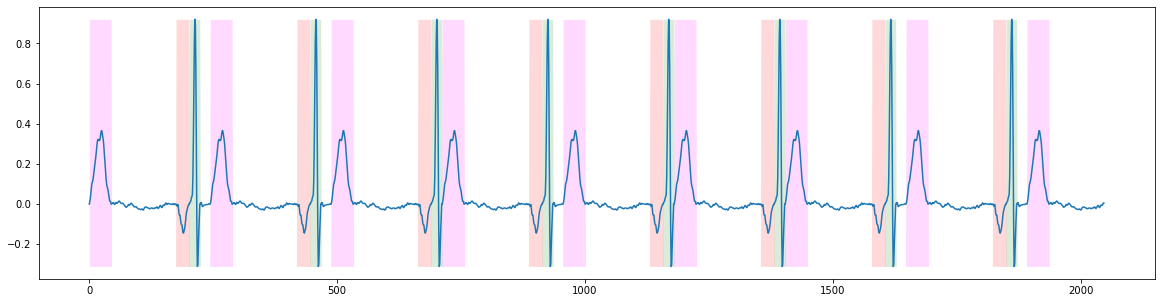

In [18]:
# %%timeit
N = 2048

# Hyperparams
size = 20
onset = np.random.randint(0,50)
begining_wave = np.random.randint(0,6)
has_P = (np.random.rand(1) > 0.1)
has_PQ = (np.random.rand(1) > 0.2)
has_ST = (np.random.rand(1) > 0.2)
has_BBB = (np.random.rand(1) > 0.9)
has_same_morph = (np.random.rand(1) > 0.25)
proba_P = 0.15
proba_PQ = 0.15
proba_QRS = 0.01
proba_ST = 0.15

##### Data structure
ids = []

##### Identifiers
if not has_same_morph:
    id_P = np.random.randint(0,len(Psignal),size=size)
    id_PQ = np.random.randint(0,len(PQsignal),size=size)
    id_QRS = np.random.randint(0,len(QRSsignal),size=size)
    id_ST = np.random.randint(0,len(STsignal),size=size)
    id_T = np.random.randint(0,len(Tsignal),size=size)
    id_TP = np.random.randint(0,len(TPsignal),size=size)
else:
    id_P = np.repeat(np.random.randint(0,len(Psignal),size=1),size)
    id_PQ = np.repeat(np.random.randint(0,len(PQsignal),size=1),size)
    id_QRS = np.repeat(np.random.randint(0,len(QRSsignal),size=1),size)
    id_ST = np.repeat(np.random.randint(0,len(STsignal),size=1),size)
    id_T = np.repeat(np.random.randint(0,len(Tsignal),size=1),size)
    id_TP = np.repeat(np.random.randint(0,len(TPsignal),size=1),size)
    
# In case QRS is not expressed
filt_QRS = np.random.rand(size) < proba_QRS

# P wave
id_P[(np.random.rand(size) < proba_P) | np.logical_not(has_P)] = -1
id_PQ[filt_QRS | (np.random.rand(size) < proba_PQ) | np.logical_not(has_PQ)] = -1
id_QRS[filt_QRS] = -1
id_ST[filt_QRS | (np.random.rand(size) < proba_ST) | np.logical_not(has_ST)] = -1
id_T[filt_QRS] = -1

beats = []
masks = []
ids = []
offset = 0
record_size = 0
mark_break = False
for i in range(size):
    for j in range(6):
        if (i == 0) and (j < begining_wave): 
            continue
        if (j == 0) and (id_P[i] != -1):
            beats.append(trailonset(Psignal[Pkeys[id_P[i]]],offset))
            masks.append(np.full((beats[-1].size,),1,dtype='int8'))
            ids.append(('P',Pkeys[id_P[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 1) and (id_PQ[i] != -1):
            beats.append(trailonset(PQsignal[PQkeys[id_PQ[i]]],offset))
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            ids.append(('PQ',PQkeys[id_PQ[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 2) and (id_QRS[i] != -1):
            beats.append(trailonset(QRSsignal[QRSkeys[id_QRS[i]]],offset))
            masks.append(np.full((beats[-1].size,),2,dtype='int8'))
            ids.append(('QRS',QRSkeys[id_QRS[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 3) and (id_ST[i] != -1):
            beats.append(trailonset(STsignal[STkeys[id_ST[i]]],offset))
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            ids.append(('ST',STkeys[id_ST[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 4) and (id_T[i] != -1):
            beats.append(trailonset(Tsignal[Tkeys[id_T[i]]],offset))
            masks.append(np.full((beats[-1].size,),3,dtype='int8'))
            ids.append(('T',Tkeys[id_T[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 5) and (id_TP[i] != -1):
            beats.append(trailonset(TPsignal[TPkeys[id_TP[i]]],offset))
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            ids.append(('TP',TPkeys[id_TP[i]]))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (record_size-onset) >= N:
            mark_break = True
            break
    if mark_break:
        break
        
# Obtain final stuff
signal = np.concatenate(beats)
masks = np.concatenate(masks)
masks_all = np.zeros((record_size,3),dtype=bool)
masks_all[:,0] = (masks == 1)
masks_all[:,1] = (masks == 2)
masks_all[:,2] = (masks == 3)

# Move onset
signal = signal[onset:onset+N]
masks_all = masks_all[onset:onset+N,:]

# Plotting
mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

plt.figure(figsize=(20,5))
plt.plot(signal)
plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()

In [ ]:
ids

In [ ]:
plt.plot(TPsignal['74_V4_5'])

In [ ]:
# i = 103
# lead = 'iii'
# rec = wfdb.rdrecord(os.path.join(basedir,'ludb','{}'.format(i)))
# ann = wfdb.rdann(os.path.join(basedir,'ludb','{}'.format(i)),'atr_{}'.format(lead.lower()))
# print(np.array(ann.symbol))
# wfdb.plot.plot_wfdb(record=rec, annotation=ann, figsize=(20,40))